# Binary classification from 2 features with Keras (Tensor Flow 2.0)

Classification using Keras, performing a classification similar to [the TensorFlow implementation](ClassificationContinuous2Features-TensorFlow.html). 

Based on the same data model as in the [binary classification](ClassificationContinuous2Features.html) workbook.

The classification is on a single boundary defined by a continuous function and added white noise.

Initial model is the logistic regression implemented with Keras. A further multi-layer model is developed in order to better fit the quadratic model of the data.

In [1]:
from tensorflow import keras # TF 2.0+ required
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
import pandas
import seaborn as sns

In [2]:
usingTensorBoard = False

## Model

Quadratic function a boundary between positive and negative values

Adding some unknown as a Gaussian noise

The values of X are uniformly distributed and independent

In [3]:
# Two features, Gaussian noise
nFeatures = 2
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.1
    std = 0.1
    #
    x = random.uniform(xMin, xMax, (N, 2))
    # 4th degree relation to shape the boundary
    boundary = 2*(x[:,0]**4 + (x[:,0]-0.3)**3 + b)
    # Adding some gaussian noise
    labels = boundary + random.normal(0, std, N) > x[:,1]
    return (x, labels)

def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(skMetrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', ylabel='True values');

### Training data

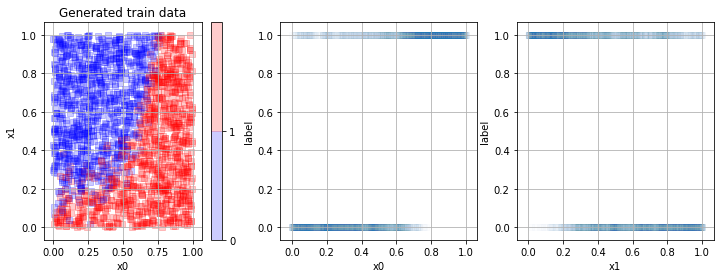

In [4]:
N = 2000
# x has 1 dim in R, label has 1 dim in B
xTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTrain[:,0], xTrain[:,1], c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.2)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated train data')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1])
plt.subplot(1,3,2)
plt.scatter(xTrain[:,0], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x0')
plt.ylabel('label')
plt.grid()
plt.subplot(1,3,3)
plt.scatter(xTrain[:,1], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x1')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.5085


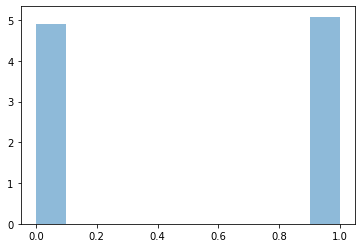

In [5]:
count, bins, ignored = plt.hist(labelTrain*1.0, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

### Test data for verification of the model

In [6]:
xTest, labelTest = generateBatch(N)
testColors = ['navy', 'orangered']

### Helpers

In [7]:
def plotTestResult(xTest, labelTest, yEst, labelEst):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.scatter(xTest[:,0], xTest[:,1], c=labelEst, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.title('Estimated')
    cb = plt.colorbar()
    loc = np.arange(0,1,1./len(testColors))
    cb.set_ticks(loc)
    cb.set_ticklabels([0,1]);
    plt.subplot(1,3,2)
    plt.hist(yEst, 10, density=True, alpha=0.5)
    plt.title('Bernouilli parameter =' + str(np.mean(labelEst)))
    plt.subplot(1,3,3)
    plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.2);
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.title('Generator')
    cb = plt.colorbar()
    loc = np.arange(0,1,1./len(colors))
    cb.set_ticks(loc)
    cb.set_ticklabels([0,1]);
    
def plotLossAccuracy(loss, accuracy):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(loss)
    plt.grid()
    plt.title('Loss')
    plt.subplot(1,3,2)
    plt.plot(accuracy)
    plt.grid()
    plt.title('Accuracy');

# Using Keras with TensorFlow backend

## Logistic regression using Keras

References:
- https://www.tensorflow.org/tutorials/keras/basic_classification
- https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [8]:
# Number of epochs
nEpoch = 200
nBatch = 32 # 32 is default

In [9]:
model = keras.models.Sequential([
  keras.layers.Dense(1, activation=keras.activations.sigmoid, input_shape=[nFeatures])
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', #'sparse_categorical_crossentropy',
              metrics=['accuracy'])
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]

hist = model.fit(xTrain, labelTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

In [10]:
weights, biases = model.get_weights()
print('Est W=', weights.reshape(-1), ', b=', biases[0])

Est W= [ 6.613447  -5.2263746] , b= -0.55753434


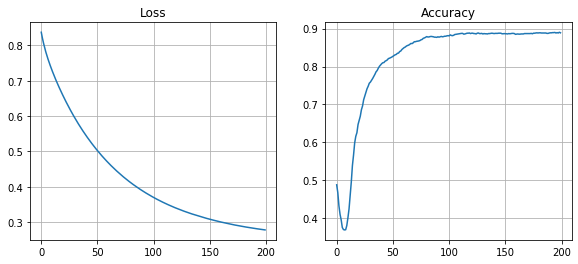

In [11]:
plotLossAccuracy(hist.history['loss'], hist.history['accuracy'])

## Testing the model

In [12]:
#model.evaluate(xTest, labelTest)
yEst = model.predict(xTest).reshape(-1)
labelEst = yEst > 0.5

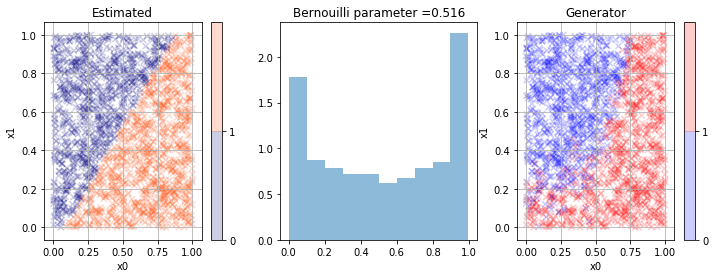

In [13]:
plotTestResult(xTest, labelTest, yEst, labelEst)

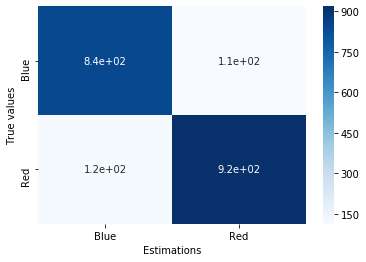

In [14]:
plotConfusionMatrix(labelTest, labelEst, np.array(['Blue', 'Red']));

In [15]:
print(skMetrics.classification_report(labelTest, labelEst))

              precision    recall  f1-score   support

       False       0.87      0.88      0.88       959
        True       0.89      0.88      0.89      1041

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [16]:
# Visualization now done using TensorBoard

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

## Adding a regularizer

We have seen in ClassificationContinuous2Features-TensorFlow that the solution is not unique. Let's add a constraint through a regularizer.

Reference: https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/

In [17]:
model2 = keras.models.Sequential([
  keras.layers.Dense(1, activation='linear', input_shape=[nFeatures],
                        bias_regularizer=keras.regularizers.l1(0.01),      # <---
                        kernel_regularizer=keras.regularizers.l1(0.01)), # <----
  keras.layers.Activation(keras.activations.sigmoid)                                      # <----
])
model2.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs2/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]

hist2 = model2.fit(xTrain, labelTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

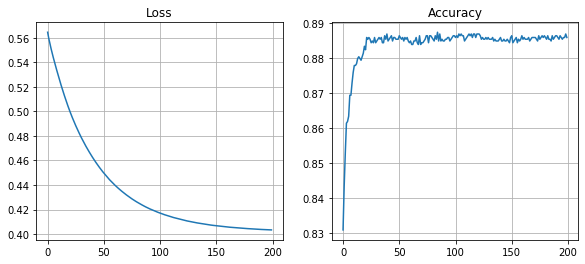

In [18]:
plotLossAccuracy(hist2.history['loss'], hist2.history['accuracy'])

In [19]:
weights2, biases2 = model2.get_weights()
print('With regularizer W=', weights2.reshape(-1), ', b=', biases2[0])

With regularizer W= [ 5.662139 -4.575111] , b= -0.3705385


With a kernel regularizer, the convergence seems faster, it depends however on the initialization values.

The weights and bias are not that different

### Testing the model with regularizer

In [20]:
yEst2 = model2.predict(xTest).reshape(-1)
labelEst2 = yEst2 > 0.5

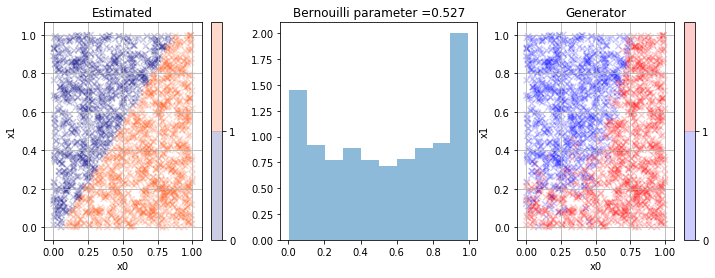

In [21]:
plotTestResult(xTest, labelTest, yEst2, labelEst2)

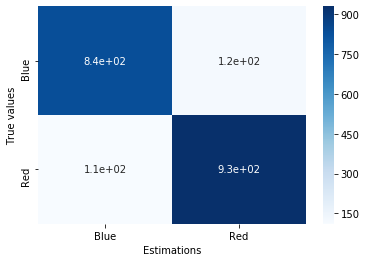

In [22]:
plotConfusionMatrix(labelTest, labelEst2, np.array(['Blue', 'Red']))

In [23]:
print(skMetrics.classification_report(labelTest, labelEst2))

              precision    recall  f1-score   support

       False       0.88      0.87      0.88       959
        True       0.88      0.89      0.89      1041

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



# Adding capacity to the model

The above model is not able to match the actual model boundary as its capacity is a simple linear, 1st degree, separation of the plan

Let's add more neurons or more layers to our model

## Two layers (4 -> 1)

In [24]:
nEpoch3 = 512
model3 = keras.models.Sequential([
  keras.layers.Dense(4, activation=keras.activations.relu, input_shape=[nFeatures], # <---
                    bias_regularizer=keras.regularizers.l1(0.01),     
                    kernel_regularizer=keras.regularizers.l1(0.01)),
  keras.layers.Dense(1, activation=keras.activations.sigmoid) # <---
])
model3.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs3/", histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
hist3 = model3.fit(xTrain, labelTrain, epochs=nEpoch3, batch_size=nBatch, verbose=0, callbacks=callbacks)

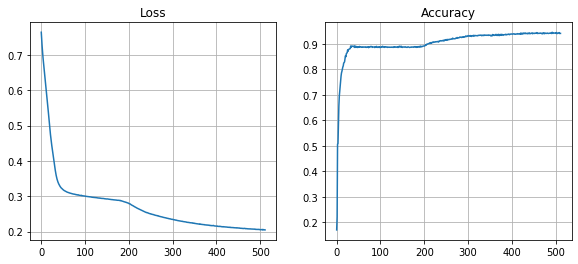

In [25]:
plotLossAccuracy(hist3.history['loss'], hist3.history['accuracy'])

In [26]:
weights3_1, biases3_1, weights3_2, biases3_2 = model3.get_weights()
print('2 Layers')
print('W1 =', weights3_1.reshape(-1))
print('b1 =', biases3_1)
print('W2 =', weights3_2.reshape(-1))
print('b2 =', biases3_2)

2 Layers
W1 = [ 5.9890741e-01  1.6685007e+00  2.5536180e-03 -4.2117099e-04
 -7.7986467e-01  5.6196753e-02  1.1522832e+00 -9.0610338e-06]
b1 = [ 3.4219748e-01 -8.2417828e-01  1.3022455e-03 -1.0507734e-05]
W2 = [ 8.008138  13.226465  -5.250704   0.3851403]
b2 = [-1.3699114]


### Testing the model with two layers

In [27]:
yEst3 = model3.predict(xTest).reshape(-1)
labelEst3 = yEst3 > 0.5

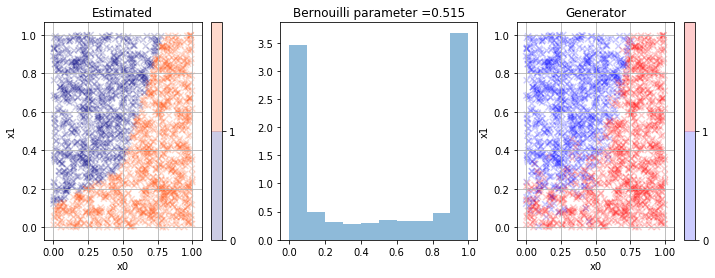

In [28]:
plotTestResult(xTest, labelTest, yEst3, labelEst3)

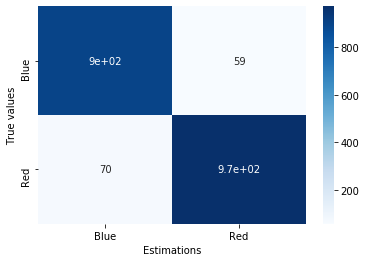

In [29]:
plotConfusionMatrix(labelTest, labelEst3, np.array(['Blue', 'Red']));

In [30]:
print(skMetrics.classification_report(labelTest, labelEst3))

              precision    recall  f1-score   support

       False       0.93      0.94      0.93       959
        True       0.94      0.93      0.94      1041

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



#### Conclusion

The network is able to match much better the generation function leading to an improvement in the accuracy from 90% to ~94%, given a gaussian noise of std=0.1.

On the accuracy plot, we see that the optimization happens in two steps: initial convergence to 90% accuracy (as the simpler network), then slower optimization from 90 to 94% of accuracy.

However, the experiments have shown much more instability of the optimizer with more layers, even sometimes failing to converge. With this network, the regularizer seems mandatory otherwise the second round of optimization is never reached.

# Where to go from here ?

__Other linear implementations and simple neural nets__ [using "raw" Python or SciKit Learn](ClassificationContinuous2Features.html) ([Notebook](ClassificationContinuous2Features.ipynb)), [using TensorFlow](ClassificationContinuous2Features-TensorFlow.html) ([Notebook](ClassificationContinuous2Features-TensorFlow.ipynb)), or the [__K Nearest Neighbors classifier__](ClassificationContinuous2Features-KNN.html) ([Notebook](ClassificationContinuous2Features-KNN.ipynb))

__More complex multi-class models__ on the Czech and Norways flags [using Keras](ClassificationMulti2Features-Keras.html) ([Notebook](ClassificationMulti2Features-Keras.ipynb)), showing one of the main motivations to neural networks.

__Compare with the two feature linear regression__ [using simple algorithms](../linear/LinearRegressionBivariate.html) ([Notebook](../linear/LinearRegressionBivariate.ipynb])), [or using Keras](../linear/LinearRegressionBivariate-Keras.html) ([Notebook](../linear/LinearRegressionBivariate-Keras.ipynb))